In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [29]:
train_data = pd.read_csv('/Users/mallikharjunaakula/Documents/Nap queens/Task 1/train.csv')
test_data = pd.read_csv('/Users/mallikharjunaakula/Documents/Nap queens/Task 1/test.csv')

# Display the first few rows 
train_data.head(), test_data.head()

(                      ID        date     Item Id  \
 0  2022-04-12_B09KDTS4DC  2022-04-12  B09KDTS4DC   
 1  2022-04-12_B09MR2MLZH  2022-04-12  B09MR2MLZH   
 2  2022-04-12_B09KSYL73R  2022-04-12  B09KSYL73R   
 3  2022-04-12_B09KT5HMNY  2022-04-12  B09KT5HMNY   
 4  2022-04-12_B09KTF8ZDQ  2022-04-12  B09KTF8ZDQ   
 
                                            Item Name  ad_spend anarix_id  \
 0  NapQueen Elizabeth 8" Gel Memory Foam Mattress...       NaN  NAPQUEEN   
 1  NapQueen 12 Inch Bamboo Charcoal Queen Size Me...       NaN  NAPQUEEN   
 2     NapQueen Elsa 8" Innerspring Mattress, Twin XL       NaN  NAPQUEEN   
 3        NapQueen Elsa 6" Innerspring Mattress, Twin       NaN  NAPQUEEN   
 4     NapQueen Elsa 6" Innerspring Mattress, Twin XL       NaN  NAPQUEEN   
 
    units  unit_price  
 0    0.0         0.0  
 1    0.0         0.0  
 2    0.0         0.0  
 3    0.0         0.0  
 4    0.0         0.0  ,
                       ID        date     Item Id  \
 0  2024-07-01_B09

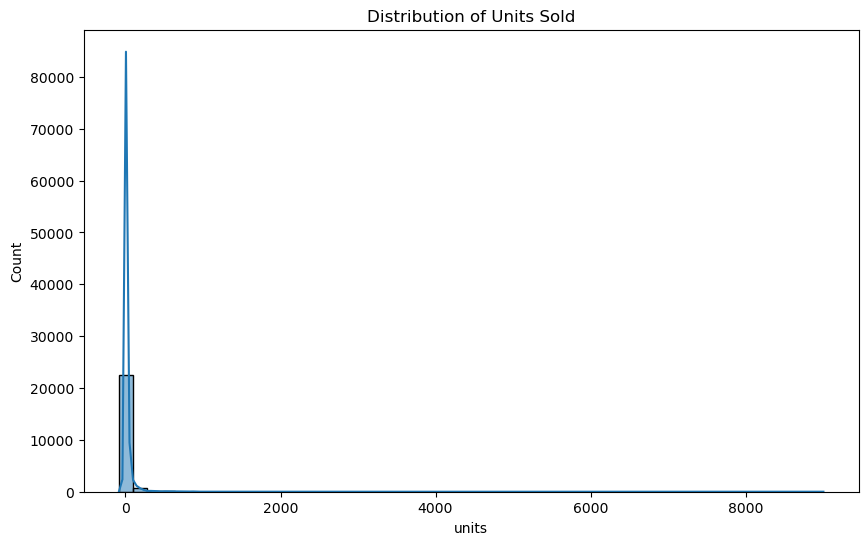

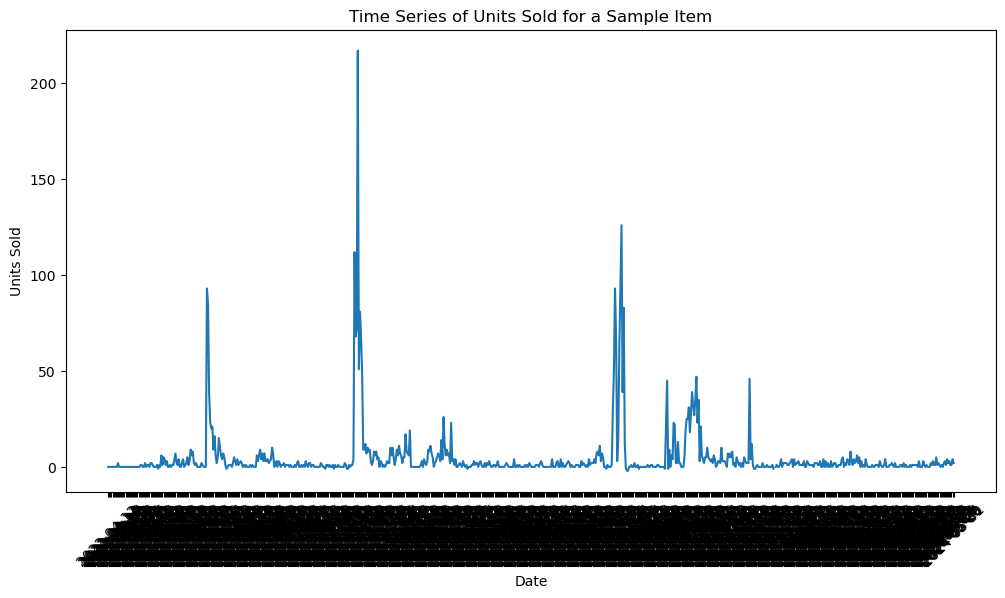

In [30]:
train_data.isnull().sum()

# Summary statistics of the train dataset
train_data.describe()

# Plotting the distribution of units sold
plt.figure(figsize=(10, 6))
sns.histplot(train_df['units'], bins=50, kde=True)
plt.title('Distribution of Units Sold')
plt.show()

# Time series plot for a sample Item Id
sample_item = train_data[train_data['Item Id'] == train_data['Item Id'].unique()[0]]
plt.figure(figsize=(12, 6))
plt.plot(sample_item['date'], sample_item['units'])
plt.title('Time Series of Units Sold for a Sample Item')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.show()

In [31]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

# Extract date features
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['dayofweek'] = train_data['date'].dt.dayofweek

test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data['dayofweek'] = test_data['date'].dt.dayofweek

# Create lag features for units in the training set
train_data['units_lag1'] = train_data.groupby('Item Id')['units'].shift(1)
train_data['units_lag7'] = train_data.groupby('Item Id')['units'].shift(7)
train_data['units_lag30'] = train_data.groupby('Item Id')['units'].shift(30)

# Create rolling statistics for units in the training set
train_data['units_roll_mean7'] = train_data.groupby('Item Id')['units'].transform(lambda x: x.rolling(7).mean())
train_data['units_roll_std7'] = train_data.groupby('Item Id')['units'].transform(lambda x: x.rolling(7).std())
train_data['units_roll_mean30'] = train_data.groupby('Item Id')['units'].transform(lambda x: x.rolling(30).mean())
train_data['units_roll_std30'] = train_data.groupby('Item Id')['units'].transform(lambda x: x.rolling(30).std())

# Drop rows with NaN values created by lag and rolling features
train_df.dropna(inplace=True)

In [37]:
import numpy as np
# Prepare data for modeling
features = ['year', 'month', 'day', 'dayofweek', 'ad_spend', 'unit_price', 'units_lag1', 'units_lag7', 'units_lag30', 'units_roll_mean7', 'units_roll_std7', 'units_roll_mean30', 'units_roll_std30']
X = train_data[features]
y = train_data['units']

# Check for NaN, infinity, or very large values in y
print(f"Before cleaning: NaNs: {y.isna().sum()}, Infinities: {np.isinf(y).sum()}, Too large values: {(y > 1e6).sum()}")

# Handle NaN, infinity, or very large values
y = y.replace([np.inf, -np.inf], np.nan)
y = y.fillna(y.median())
y = y.clip(upper=y.quantile(0.99))

print(f"After cleaning: NaNs: {y.isna().sum()}, Infinities: {np.isinf(y).sum()}, Too large values: {(y > 1e6).sum()}")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f'Validation Mean Square Error: {mse}')

Before cleaning: NaNs: 17898, Infinities: 0, Too large values: 0
After cleaning: NaNs: 0, Infinities: 0, Too large values: 0
Validation Mean Square Error: 40.44769716125222


In [38]:
#Hyperparameter tuning

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [40]:
# Ensure there are no NaN values in the test set
test_data.fillna(0, inplace=True)

# Add placeholder lag and rolling features in the test set
test_data['units_lag1'] = 0
test_data['units_lag7'] = 0
test_data['units_lag30'] = 0
test_data['units_roll_mean7'] = 0
test_data['units_roll_std7'] = 0
test_data['units_roll_mean30'] = 0
test_data['units_roll_std30'] = 0

# Prepare test data
features = ['year', 'month', 'day', 'dayofweek', 'ad_spend', 'unit_price', 'units_lag1', 'units_lag7', 'units_lag30', 'units_roll_mean7', 'units_roll_std7', 'units_roll_mean30', 'units_roll_std30']
X_test = test_data[features]

# Predict the units sold
test_data['TARGET'] = best_model.predict(X_test)

# Create the Item column
test_data['Item'] = test_data.apply(lambda row: f"{row['date'].strftime('%Y-%m-%d')}_{row['Item Id']}", axis=1)

# Create submission file
submission = test_data[['Item','TARGET']]
submission.to_csv('/Users/mallikharjunaakula/Documents/Nap queens/Task 1/submission.csv', index=False)

# Task 2

In [42]:
# Prepare data for modeling without 'ad_spend'
features = ['year', 'month', 'day', 'dayofweek', 'unit_price', 'units_lag1', 'units_lag7', 'units_lag30', 'units_roll_mean7', 'units_roll_std7', 'units_roll_mean30', 'units_roll_std30']
X = train_df[features]
y = train_df['units']

# Check for NaN, infinity, or very large values in y
print(f"Before cleaning: NaNs: {y.isna().sum()}, Infinities: {np.isinf(y).sum()}, Too large values: {(y > 1e6).sum()}")

# Handle NaN, infinity, or very large values
y = y.replace([np.inf, -np.inf], np.nan)
y = y.fillna(y.median())
y = y.clip(upper=y.quantile(0.99))

print(f"After cleaning: NaNs: {y.isna().sum()}, Infinities: {np.isinf(y).sum()}, Too large values: {(y > 1e6).sum()}")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f'Validation Mean Square Error: {mse}')


Before cleaning: NaNs: 0, Infinities: 0, Too large values: 0
After cleaning: NaNs: 0, Infinities: 0, Too large values: 0
Validation Mean Square Error: 283.22200933221495


In [43]:
# Ensure there are no NaN values in the test set
test_df.fillna(0, inplace=True)

# Add placeholder lag and rolling features in the test set
test_df['units_lag1'] = 0
test_df['units_lag7'] = 0
test_df['units_lag30'] = 0
test_df['units_roll_mean7'] = 0
test_df['units_roll_std7'] = 0
test_df['units_roll_mean30'] = 0
test_df['units_roll_std30'] = 0

# Prepare test data without 'ad_spend'
features_test = ['year', 'month', 'day', 'dayofweek', 'unit_price', 'units_lag1', 'units_lag7', 'units_lag30', 'units_roll_mean7', 'units_roll_std7', 'units_roll_mean30', 'units_roll_std30']
X_test = test_df[features_test]

# Predict the units sold
test_df['TARGET'] = model.predict(X_test)

# Create the Item column
test_df['Item'] = test_df.apply(lambda row: f"{row['date'].strftime('%Y-%m-%d')}_{row['Item Id']}", axis=1)

# Create submission file
submission = test_df[['date', 'Item Id', 'TARGET', 'Item']]
submission.to_csv('/Users/mallikharjunaakula/Documents/Nap queens/submission_task2.csv', index=False)